# Практическая работа №2: Кластерный анализ. Метод k-средних

Выполнили студенты гр. 0383 Желнин Максим, Рудакова Юлия, Сергевнин Дмитрий. Вариант №12


## Цель работы

Освоение основных понятий и некоторых методов кластерного анализа, в частности, метода k-means.

## Основные теоретические положения

**Кластер** — класс элементов статистической совокупности, объединённых каким-либо критерием.

**Центр кластера** – среднее геометрическое место точек, принадлежащих
кластеру, в пространстве данных.

**Расстояние** между объектами a и b в пространстве называется
величина $d_{ab}$, удовлетворяющая аксиомам:
1. $d_{ab}$ > 0, если 𝑎 ≠ 𝑏
2. $d_{ab}$ = $d_{ba}$
3. $d_{ab}$ = 0, если 𝑎 = 𝑏
4. $d_{ab}$ + $d_{bc}$ ≥ $d_{ac}$

**Метод k-средних** используется для группировки данных путем разделения векторного пространства на заранее определенное количество кластеров k. Алгоритм представляет собой итеративный процесс, включающий следующие шаги:
1. Определение числа кластеров k.
2. Случайным образом выбор k наблюдений из исходного набора данных в качестве начальных центров кластеров.
3. Назначение каждому наблюдению исходного набора ближайшего центра кластера (расстояния измеряются в метрике Евклида), что приводит к формированию начальных кластеров.
4. Вычисление центроидов - центров тяжести кластеров. Каждый центроид представляет собой вектор, элементы которого являются средними значениями соответствующих признаков, вычисленными по всем записям кластера.
5. Смещение центра кластера к его центроиду, после чего центроид становится новым центром кластера.
6. Повторение 3-го и 4-го шагов итеративно. Каждая итерация приводит к изменению границ кластеров и смещению их центров, что минимизирует расстояние между элементами внутри кластеров и увеличивает межкластерные расстояния.

Метод к-средних относится к **неирархическим методам кластеризации**, т.е. основаных на разделении, представляющие собой итеративные методы дробления исходной совокупности.


## Постановка задачи

Дано конечное множество из объектов, представленных двумя признаками (в качестве этого множества принимаем исходную двумерную выборку, сформированную ранее в практической работе №4). Выполнить разбиение исходного множества объектов на конечное число подмножеств (кластеров) с использованием метода k-means. Полученные результаты содержательно проинтерпретировать.

## Выполнение работы


###Подготовка

Загрузим датасет из предыдущих работ и импортируем зависимости



In [147]:
import pandas as pd
import numpy as np
import io
import zipfile
from google.colab import files
import matplotlib.pyplot as plt

In [148]:
uploaded = files.upload()

Saving sample.zip to sample.zip


In [149]:
# Извлекаем файл sample.csv из архива
with zipfile.ZipFile(io.BytesIO(uploaded['sample.zip']), 'r') as zip_ref:
    zip_ref.extractall()
N = 111
sample = pd.read_csv('sample.csv', skiprows=3).sample(n=N, random_state=1).reset_index(drop='true')

###**Пункт 1**

Нормализовать множество точек из предыдущего раздела, отобразить полученное множество.

In [150]:
sample["nu"] = (sample["nu"] - sample["nu"].mean()) / sample["nu"].std()
sample["E"] = (sample["E"] - sample["E"].mean()) / sample["E"].std()
sample

,nu,E
0,0.358744,0.589884
1,1.426981,0.745899
2,-0.430108,-0.613075
3,0.753170,0.327121
4,-1.350435,-1.926887
...,...,...
106,-1.054616,-0.842992
107,0.325875,-0.247671
108,-0.282198,-0.555596
109,-0.331501,-0.744456


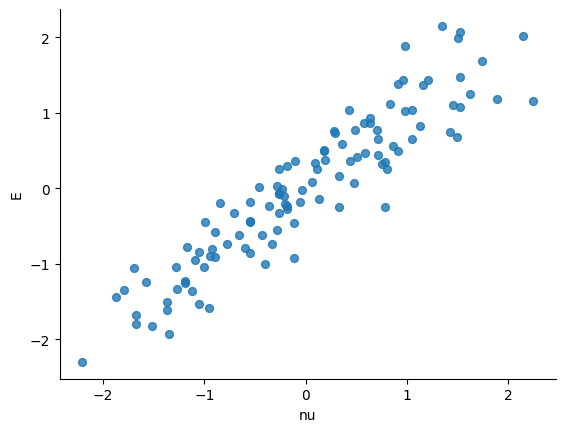

In [151]:
sample.plot(kind='scatter', x='nu', y='E', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

###**Пункт 2**

Определить «грубую» верхнюю оценку количества кластеров 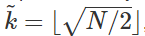

In [152]:
k = int(np.floor(np.sqrt(N/2)))
k

7

###**Пункт 3-6**

Реализовать алгоритм k-means в двух вариантах:
a. пересчет центра кластера осуществляется после каждого изменения его состава;
b. пересчет центра кластера осуществляется лишь после того, как будет завершен просмотр всех данных (шаг процедуры).

####a.

Выберем случайные центры:

In [153]:
centers = sample.sample(n=k, random_state=1).reset_index(drop='true')
centers

,nu,E
0,-0.923140,-0.806041
1,-1.054616,-1.528638
2,-0.709493,-0.325679
3,0.786039,0.351755
4,-0.545149,-0.444743
5,-1.186091,-1.224819
6,-0.117854,-0.921000


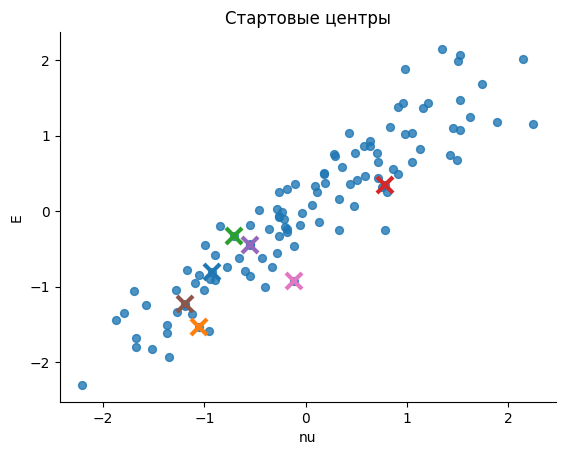

In [154]:
sample.plot(kind='scatter', x='nu', y='E', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)
for i in range(k):
    plt.plot(centers.iloc[i, 0], centers.iloc[i, 1], marker="x", mew=3, ms=12)
plt.title("Стартовые центры")
plt.show()

Для опредеделения расстояния между точками будем использовать Евклидово расстояние.

Определим функции для расчётов функционала

In [155]:
def calculate_dist_to_center(cluster, center):
  return np.sum((np.array(cluster) - np.array(center))**2)

def f1(clusters, centers):
    result = 0
    for i in range(len(clusters)):
        result += calculate_dist_to_center(clusters[i], centers.loc[i])
    return result

def f2(clusters):
    result = 0
    for i in range(len(clusters)):
        for j in range(len(clusters[i])):
            for k in range(j+1, len(clusters[i])):
                result += np.linalg.norm(np.array(clusters[i][j]) - np.array(clusters[i][k]))
    return result

def f3(clusters, centers):
    result = 0
    for i in range(len(clusters)):
        result += calculate_dist_to_center(clusters[i], centers.loc[i]) / len(clusters[i])
    return result

In [156]:
def calculate_centers(clusters, centers):
    for i in range(len(clusters)):
        if len(clusters[i]) > 0:
            centers.loc[i] = np.mean(clusters[i], axis=0)
    return centers

In [159]:
def create_clusters(df, centers, isA):
    clusters = [[] for i in range(len(centers))]
    for i in range(len(df)):
      clusters[np.argmin(np.linalg.norm(df.loc[i] - centers, axis=1))].append(list(df.loc[i]))
      if isA:
          centers = calculate_centers(clusters, centers)
    if not isA:
        centers = calculate_centers(clusters, centers)
    return clusters, centers

def plot_splitting(clusters, centers, iter):
    for i in range(len(clusters)):
        plt.scatter(np.array(clusters[i])[:, 0], np.array(clusters[i])[:, 1], s=32, alpha=.8)
        plt.plot(centers.loc[i, "nu"], centers.loc[i, "E"], marker="x", mew=3, ms=12)
    plt.gca().spines[['top', 'right',]].set_visible(False)
    plt.xlabel("nu")
    plt.ylabel("E")
    plt.title(f"Кластеры iter № {iter}")
    plt.show()

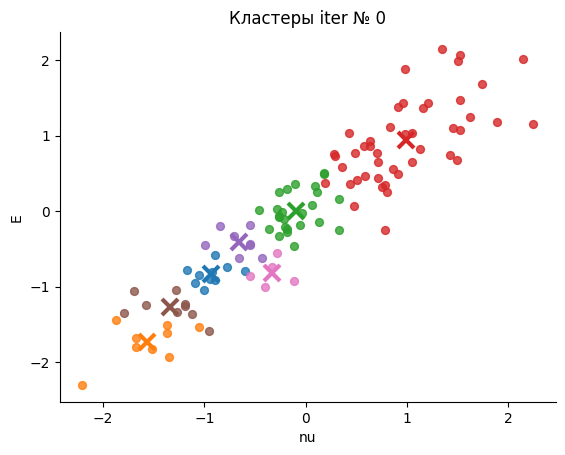

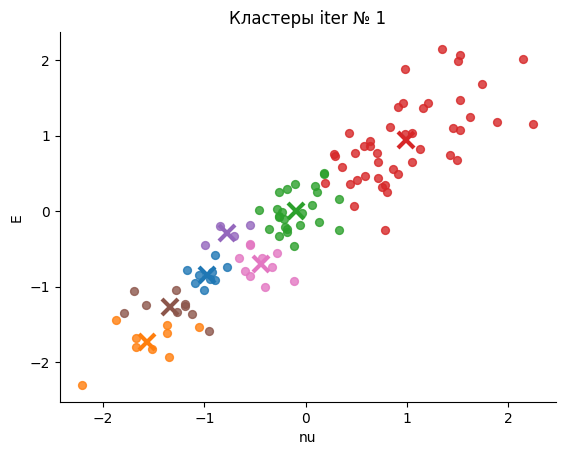

F1: 30.835757332561343, F2: 1100.955010651939, F3: 1.0463791695841445


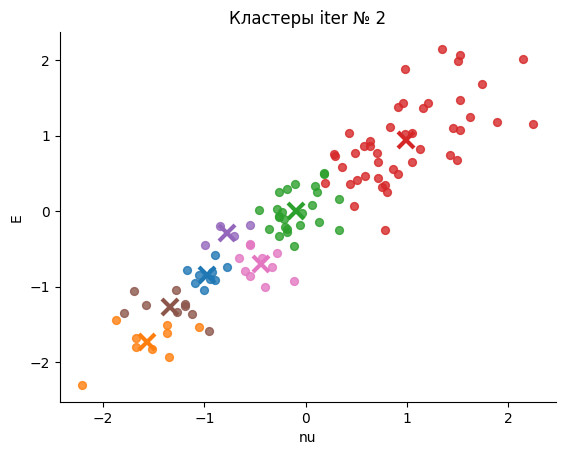

In [176]:
centers_A = centers.copy()
clusters_A = None
f1_a, f2_a, f3_a = [], [], []
updated_A, centers_A = create_clusters(sample, centers_A, True)
counter = 0
while (True):
    clusters_A = updated_A.copy()
    f1_a.append(f1(updated_A, centers_A))
    f2_a.append(f2(updated_A))
    f3_a.append(f3(updated_A, centers_A))
    plot_splitting(updated_A, centers_A, counter)
    updated_A, centers_A = create_clusters(sample, centers_A, True)
    counter += 1
    if(clusters_A == updated_A):
        print(f'F1: {f1(updated_A, centers_A)}, F2: {f2(updated_A)}, F3: {f3(updated_A, centers_A)}')
        plot_splitting(updated_A, centers_A, counter)
        break

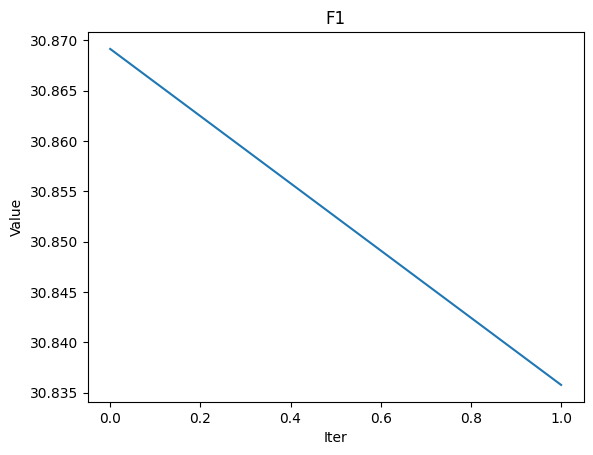

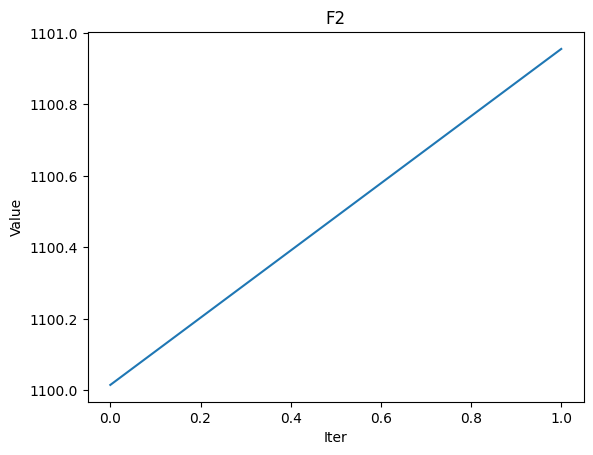

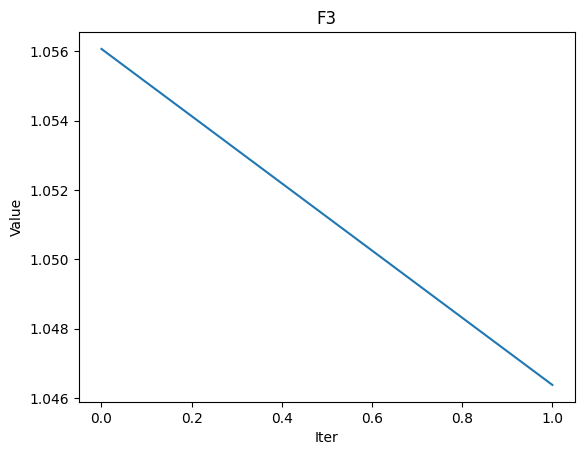

In [177]:
plt.plot(f1_a)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F1')
plt.show()
plt.plot(f2_a)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F2')
plt.show()
plt.plot(f3_a)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F3')
plt.show()

**Вывод по пункту:**

F2 Незначительно сдеградировал, в то время как F1 и F3 улучшились. Алгоритм завершился за 2 итерации

####b.

Iter № 0


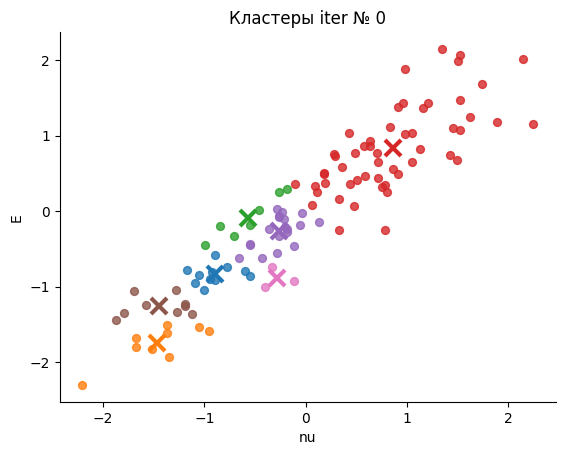

Iter № 1


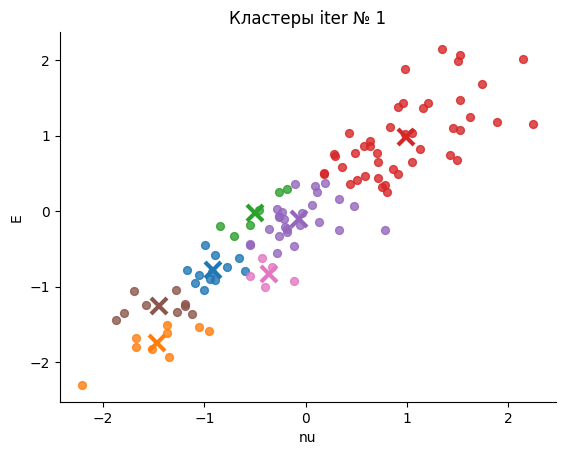

Iter № 2


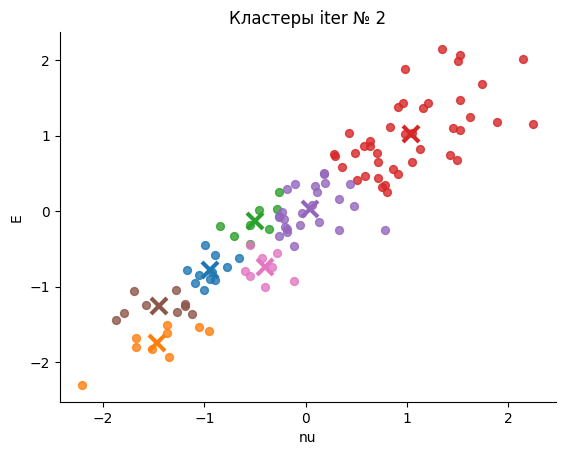

Iter № 3


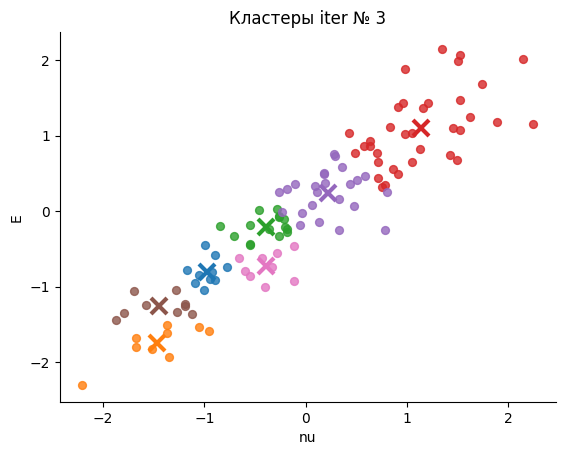

Iter № 4


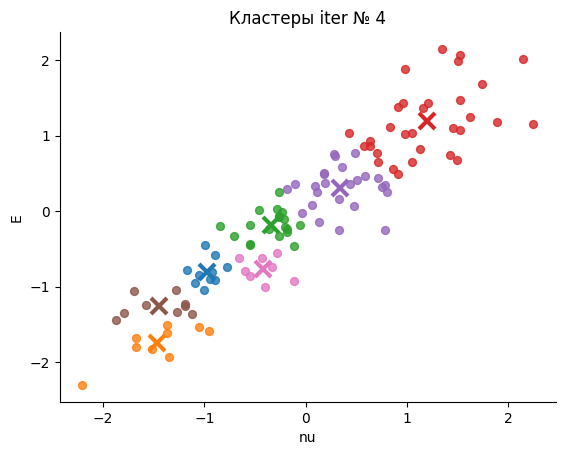

Iter № 5


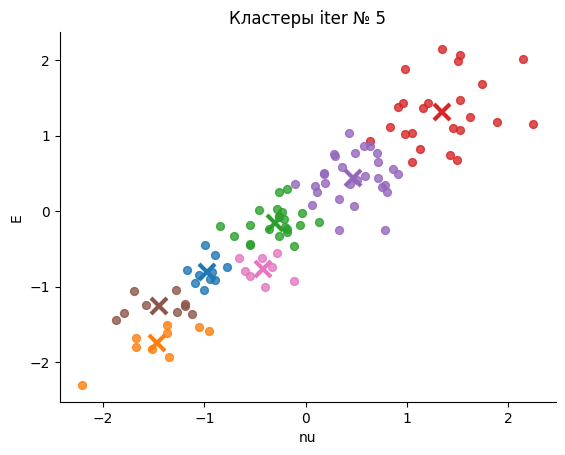

Iter № 6


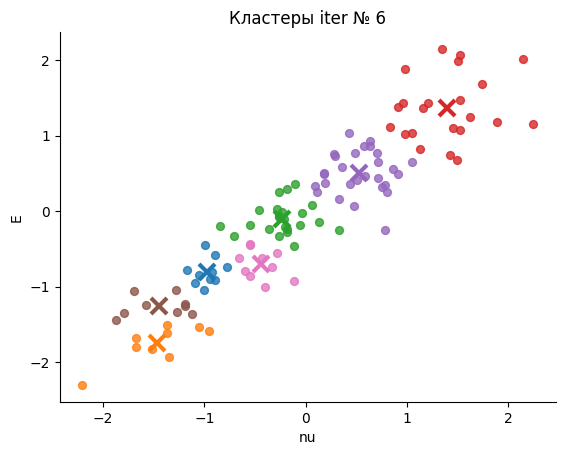

Iter № 7


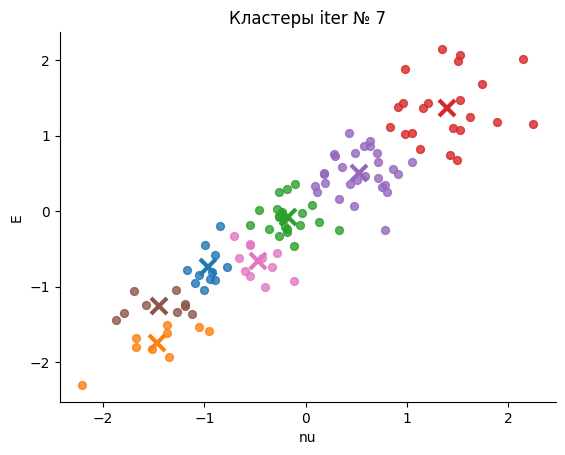

Iter № 8


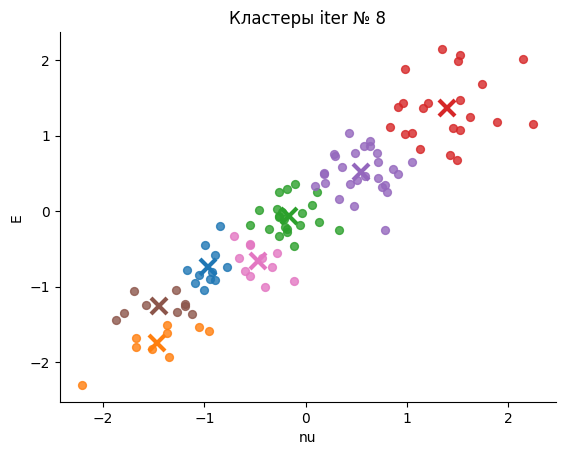

Iter № 9


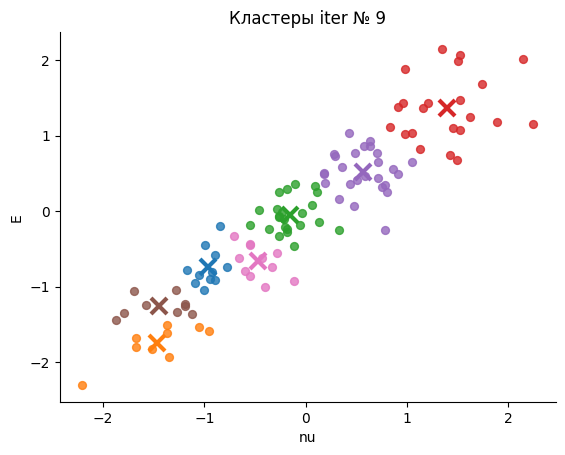

Iter № 10


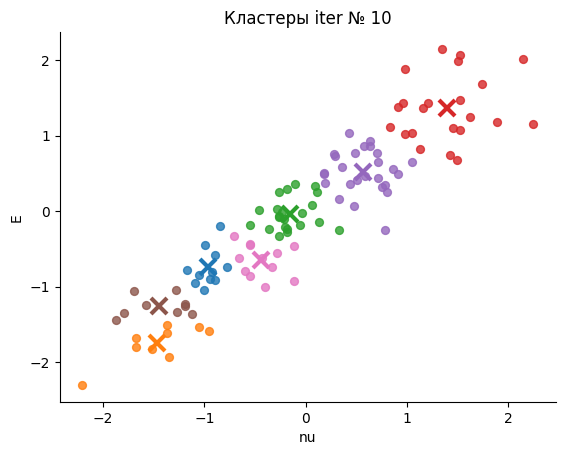

Iter № 11
F1: 16.60289431967244, F2: 492.0861427430443, F3: 0.9587394195800942


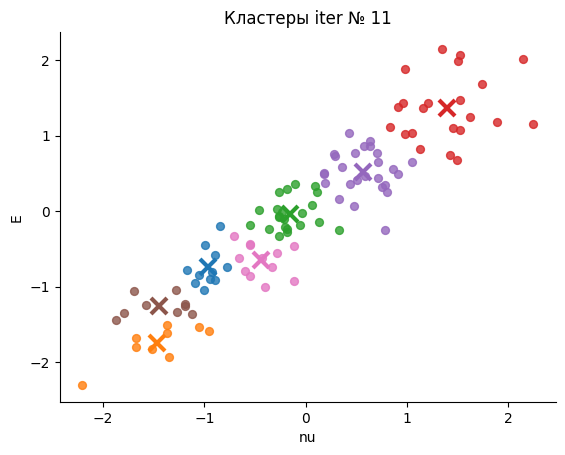

In [174]:
centers_B = centers.copy()
f1_b, f2_b, f3_b = [], [], []
clusters_B = None
updated_B, centers_B = create_clusters(sample, centers_B, False)
counter = 0
while (True):
    clusters_B = updated_B.copy()
    f1_b.append(f1(updated_B, centers_B))
    f2_b.append(f2(updated_B))
    f3_b.append(f3(updated_B, centers_B))
    plot_splitting(updated_B, centers_B, counter)
    updated_B, centers_B = create_clusters(sample, centers_B, False)
    counter += 1
    if(clusters_B == updated_B):
        print(f'F1: {f1(updated_B, centers_B)}, F2: {f2(updated_B)}, F3: {f3(updated_B, centers_B)}')
        plot_splitting(updated_B, centers_B, counter)
        break

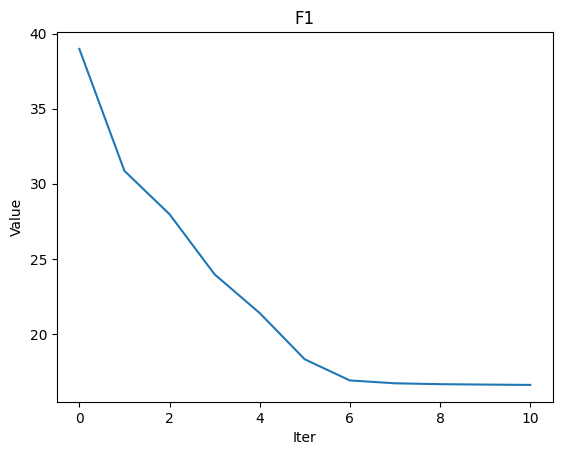

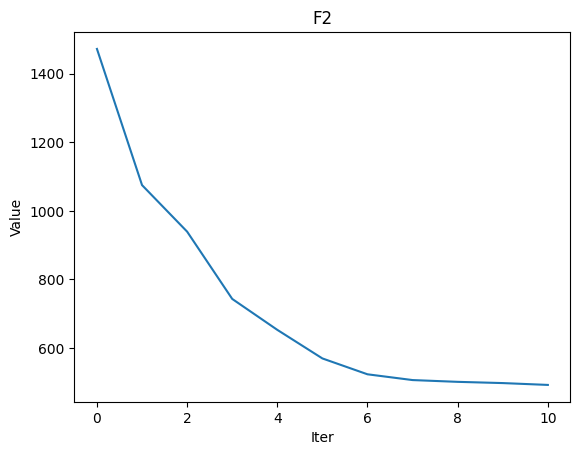

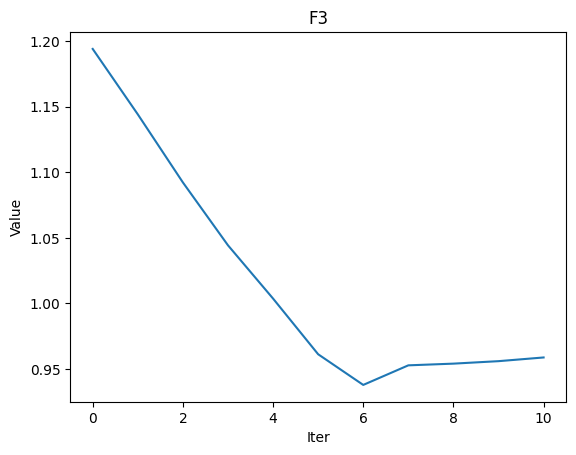

In [175]:
plt.plot(f1_b)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F1')
plt.show()
plt.plot(f2_b)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F2')
plt.show()
plt.plot(f3_b)
plt.xlabel('Iter')
plt.ylabel('Value')
plt.title('F3')
plt.show()

**Выводы по пункту:**

Можно заметить, что F1 и F2 стабильно с каждой итерацией падали, а вот F3 начал ухудшать свои показатели на более поздних итерациях, относительно предыдущих.

##Вывод

В ходе практической работы было проведено разделение двумерной выборки на кластеры с помощью алгоритма k-средних в двух вариантах: с пересчетом центра кластера после каждого изменения его состава и с пересчетом центра после завершения просмотра всех данных. Для определения расстояния между точками использовалось Евклидово расстояние. На каждом шаге каждого алгоритма были вычислены значения функционального качества разделения. Из изменений значений функционального качества в процессе выполнения алгоритмов можно сделать вывод, что каждая итерация в целом улучшает общие показатели близости расположения точек в итоговых кластерах, однако некоторые метрики имели и отрицательные тенденции.